In [2]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [3]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [4]:
import pandas as pd

In [5]:
df_collar = pd.read_csv("../data/locations.csv")

../data/2309.csv, base freq:75 Hz


Text(0, 0.5, 'Voltage (mV/Am2)')

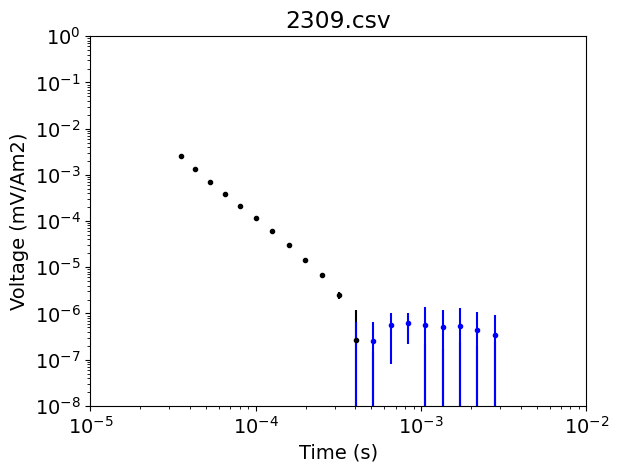

In [6]:
kk = 8
ii = 3
#colors = ['k', 'b']

df = pd.read_csv(folder_path+csv_files[kk])
df_group = df.groupby('f (Hz)')
base_freqs  = list(df_group.groups.keys())

base_freq = base_freqs[ii]
print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
df_tmp = df_group.get_group(base_freq)
voltage = df_tmp['V (mV/Am2)'].values
noise = df_tmp['N (mV/Am2)'].values
times = df_tmp['Time (s)'].values
plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
plt.xscale('log')
plt.yscale('log')
# plt.loglog(times, noise, '.')
plt.ylim(1e-8, 1)
plt.xlim(1e-5, 1e-2)
plt.title(csv_files[kk])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")

In [7]:
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

In [8]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(voltage) * np.ones(np.shape(voltage))

In [9]:
data_object = data.Data(survey, dobs=-voltage, standard_deviation=uncertainties)

In [10]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [11]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [12]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [13]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [14]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [15]:
#BFI Model (Small lake)
ice_depth=20
#water_depth=7.1 #adjusted based on report
resistive_body_1_depth=200 #chnaged depth
conductive_body_depth=30


ice_res=110
#water_res=111. #adjusted based on report
resistive_body_1_res=9500. #change name
conductive_body_res=150

resistive_body_2_res=8000


layer_thicknesses_model = np.array([ice_depth, resistive_body_1_depth, conductive_body_depth], dtype=float)
resistivities = np.array([ice_res, resistive_body_1_res, conductive_body_res, resistive_body_2_res], dtype=float)
conductivities = 1.0 / resistivities  # S/m
conductivity_model = np.log(conductivities)


In [16]:
n_layers_model = len(layer_thicknesses_model) + 1

Text(0.5, 0, 'Resistivity (Ω·m)')

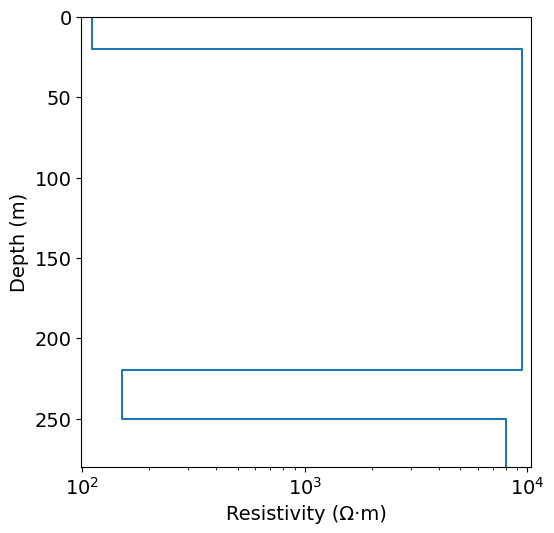

In [22]:
ax=plot_1d_layer_model(layer_thicknesses_model, resistivities)
ax.set_xlabel("Resistivity (Ω·m)")

In [18]:
model_map=maps.ExpMap(nP=n_layers_model)

In [19]:
simulation_L3=tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses_model, sigmaMap=model_map)

In [20]:
source_area = 10000

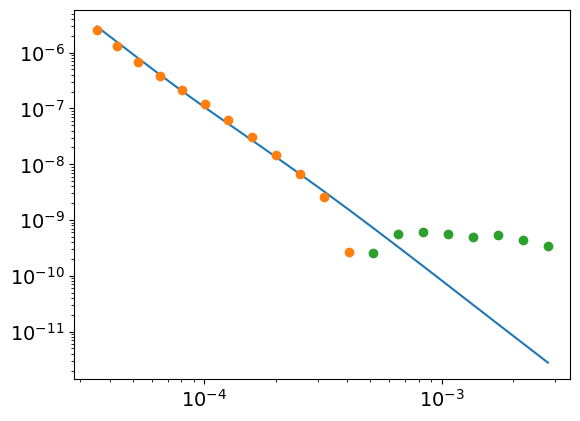

In [21]:
m0 = np.log(1./100 * np.ones(n_layers))
dpred = simulation_L2.dpred(m0)
dpred2=simulation_L3.dpred(conductivity_model)
plt.loglog(times, -dpred2, '-')
#plt.loglog(times, -dpred)
plt.loglog(times, voltage*1e-3, 'o')
plt.loglog(times, -voltage*1e-3, 'o')
#print(n_layers)
#print(n_layers_model)